# LSTM - Long Short Term Memory Networks
Las redes LSTM son un tipo de red neuronal recurrente (RNN) con capacidad para retener y utilizar información a largo plazo. Mediante el uso de unidades de memoria especializadas, las LSTM son capaces de manejar dependencias a largo plazo en secuencias de datos y evitar el problema del desvanecimiento del gradiente, que podría hacer que las RNN simples olvidaran información relevante en secuencias largas.

Las denominadas celdas de memoria, que permiten a la red recordar u olvidar información de manera selectiva a lo largo del tiempo, tienen la siguiente estructura:

+ Puerta de olvido: decide qué información descartar de la celda de memoria.
+ Puerta de entrada: decide qué nueva información se debe agregar.
+ Puerta de salida: decide qué parte de la información actual de la celda se debe pasar a la siguiente capa de la red.

A continuación, se presenta un diagrama de la arquitectura de una red LSTM:

![LSTM.png](img/LSTM.png)

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

2024-05-11 07:10:50.966935: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 07:10:51.172375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 07:10:51.172537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 07:10:51.211430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 07:10:51.304106: I tensorflow/core/platform/cpu_feature_guar

# Carga de los datos y división en training y validation

In [2]:
df = pd.read_csv('./data/goemotions_clean.csv', sep=",")
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [3]:
# División del dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

## Preprocesamiento de los datos: Tokenización, Padding y Sequenciación
Antes de poder emplear los datos en la red neuronal, es crucial preprocesarlos adecuadamente. Dado que las redes neuronales no pueden interpretar texto, este debe ser convertido a números. Para ello, se utiliza la clase Tokenizer de Keras, la cual transforma el texto en secuencias numéricas. Además, para asegurar uniformidad en el procesamiento, se agrega relleno (padding) a las secuencias, garantizando que todas posean la misma longitud.

In [4]:
def tokenization(tokenizer: Tokenizer, X_train: pd.Series, X_test: pd.Series) -> tuple[np.ndarray, np.ndarray, int, int]:
    # Ajustar el tokenizador en el conjunto de entrenamiento:
    tokenizer.fit_on_texts(X_train)

    # Convertir el texto en secuencias numéricas:
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Obtención de la longitud de la secuencia más larga:
    max_seq_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

    # Obtención del tamaño del vocabulario:
    vocab_size = len(tokenizer.word_index) + 1
    
    # Padding: 
    train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
    test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

    return train_padded, test_padded, max_seq_len, vocab_size, tokenizer

In [5]:
# Definición del Tokenizador:
tokenizer = Tokenizer(oov_token="<OOV>")
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val)

In [6]:
# Conversión del output a números
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Modelo de la red neuronal LSTM

Una vez procesados los datos, se procede a construir un modelo de red neuronal para procesar secuencias de texto con el objetivo de clasificarlas en una de 23 categorías posibles. A continucación se resumen cada una de las partes:

+ Embedding Layer: Transforma los índices enteros de palabras en vectores densos de longitud fija. Esto es crucial para procesar secuencias de texto en redes neuronales.

+ Bidirectional LSTM Layer: Una capa LSTM bidireccional procesa la secuencia de entrada en ambas direcciones (hacia adelante y hacia atrás), capturando así tanto el contexto anterior como el posterior de cada palabra. Esto ayuda a capturar relaciones de largo plazo en los datos de texto.

+ Flatten Layer: Transforma los datos de salida de la capa LSTM bidireccional en un vector unidimensional.

+ Dropout Layer: Aplica regularización de abandono para reducir el sobreajuste, aleatoriamente eliminando conexiones entre las neuronas durante el entrenamiento para evitar la dependencia entre ellas.

+ Dense Layers: Dos capas densas adicionales procesan el vector unidimensional resultante de la capa de aplanamiento. La primera capa densa utiliza la función de activación ReLU para introducir no linealidad en el modelo, mientras que la segunda capa densa utiliza la función de activación softmax para generar una distribución de probabilidad sobre las 23 clases de salida posibles.

+ Compilación del Modelo: Se compila el modelo especificando el optimizador "adam", la función de pérdida "sparse_categorical_crossentropy" para problemas de clasificación con varias clases y la métrica "accuracy" para evaluar el rendimiento del modelo durante el entrenamiento y la evaluación. Además, se ha agregado una regularización L2 al kernel de la segunda capa densa para penalizar los pesos grandes y evitar el sobreajuste.

In [7]:
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len))

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01))) # Anadimos una regularización L2 para penalizar los pesos grandes y ver si disminuye el overfit

# Output layer
model.add(Dense(23, activation="softmax"))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-05-11 07:11:08.476994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


2024-05-11 07:11:08.644436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 07:11:08.644678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 07:11:08.646501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Entrenamiento del modelo:

In [8]:
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [9]:
model_path = os.path.join(models_dir, "lstm_l2_model.keras")

Se configuran también las siguientes componentes adicionales del modelo:

+ EarlyStopping: callback que detiene el entrenamiento del modelo si no observa una mejora en la métrica de pérdida en el conjunto de validación durante un número especificado de épocas consecutivas.

+ ModelCheckpoint: callback que guarda el modelo como un archivo en el disco después de cada época si se ha observado una mejora en la métrica de pérdida en el conjunto de validación.

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [11]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs = 20,
    batch_size = 64,
    shuffle = True,
    validation_data = (val_padded, np.array(y_val)),
    callbacks = [es, mc]
)

Epoch 1/20


2024-05-11 07:11:15.948537: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdd02df5190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-11 07:11:15.948581: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-11 07:11:15.974417: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 07:11:16.017467: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1715411476.142944    4579 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1346/1346 [==============================] - ETA: 0s - loss: 2.7174 - accuracy: 0.2856
Epoch 1: val_loss improved from inf to 2.54627, saving model to ./models/lstm_l2_model.keras
1346/1346 [==============================] - 124s 87ms/step - loss: 2.7174 - accuracy: 0.2856 - val_loss: 2.5463 - val_accuracy: 0.3037
Epoch 2/20
1346/1346 [==============================] - ETA: 0s - loss: 2.4560 - accuracy: 0.3187
Epoch 2: val_loss improved from 2.54627 to 2.42034, saving model to ./models/lstm_l2_model.keras
1346/1346 [==============================] - 109s 81ms/step - loss: 2.4560 - accuracy: 0.3187 - val_loss: 2.4203 - val_accuracy: 0.3242
Epoch 3/20
1346/1346 [==============================] - ETA: 0s - loss: 2.3290 - accuracy: 0.3304
Epoch 3: val_loss improved from 2.42034 to 2.38488, saving model to ./models/lstm_l2_model.keras
1346/1346 [==============================] - 108s 80ms/step - loss: 2.3290 - accuracy: 0.3304 - val_loss: 2.3849 - val_accuracy: 0.3230
Epoch 4/20
1346/1346 [

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 128)           3526016   
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 23)                1495      
                                                        

In [13]:
def plot_metric_curves(epochs, train_curve, val_curve, train_color, val_color, metric, epochs_interval: int = 1):
    # Set graphics format as svg
    set_matplotlib_formats('svg')
    # Add grid
    sns.set_style("whitegrid")
    # Set figure size
    plt.figure(figsize=(12,8), dpi=200)
    # Plot curves
    plt.plot(epochs, train_curve, color=train_color, linewidth=2, label=f'Training {metric.lower()}')
    plt.plot(epochs, val_curve, color=val_color, linewidth=2, label=f'Validation {metric.lower()}')
    # Set title and labels
    plt.title(f'Training and validation {metric.lower()}', fontsize=20)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    # Show epoch values in x-axis in the specified interval
    plt.xticks(epochs[::epochs_interval])
    # Set max x-axis as the last epoch + 1
    plt.xlim(0, epochs[-1] + 1)
    # Remove top and right spines
    sns.despine(left=True, bottom=True)
    # Put the legend outside of the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.show()
    return

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

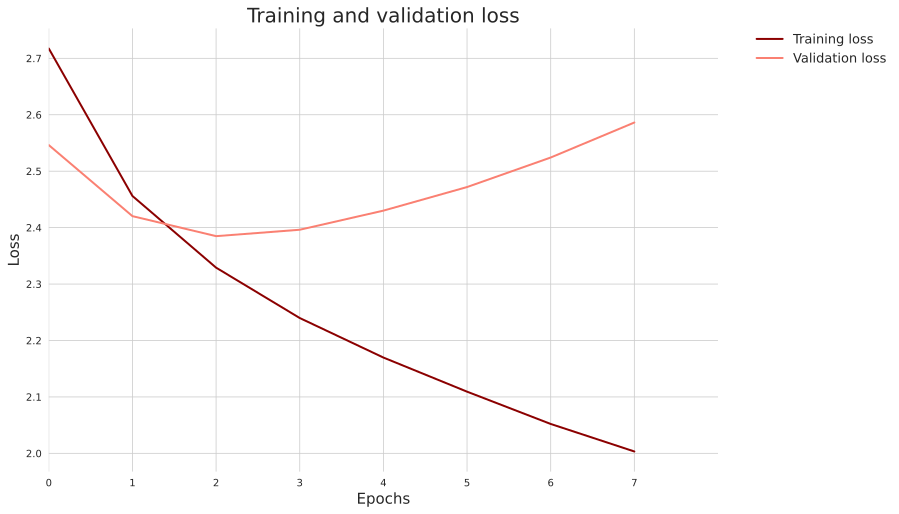

In [15]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss", 1)

Una vez entrenado el modelo, se analiza la pérdida. Tal y como se observa en la gráfica anterior, la pérdida en el entrenamiento disminuye de forma constante. Aun así, para el conjunto de validación, después de disminuir inicialmente, la pérdida comienza a aumentar lo que indica overfit. 

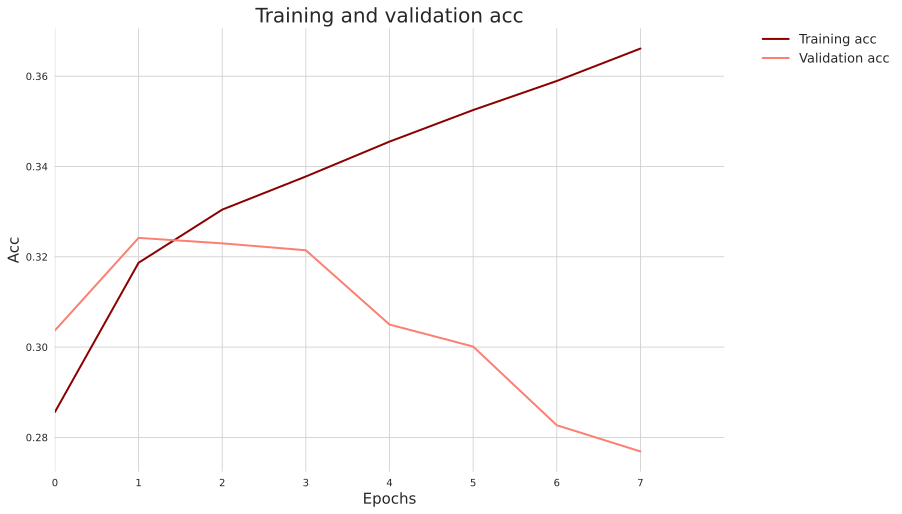

In [16]:
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "acc", 1)

Al igual que en la gráfica de la pérdida, en la de la precisión se observa cierto overfit. Analizando la imagen anterior, se puede observar como el accuracy del conjunto de validación, aunque comienza aumentando, tiende a disminuir.

# Predicciones

In [17]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(val_padded)

# Obtener las etiquetas originales de las emociones
y_val_labels = label_encoder.inverse_transform(y_val)
emotion_labels = label_encoder.classes_

673/673 [==============================] - 7s 10ms/step


In [18]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [19]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,Maybe could put context wa responding someone ...,😐 34%,👎 12%,😕 11%
1,NAME like picking choosing life work fact work,😐 25%,🤩 21%,👍 11%
2,How people eat paper plate theyre bbq,😐 34%,😕 17%,🤔 16%
3,Thank voice reason people keep screaming Vatic...,🙏 78%,😐 5%,🤩 3%
4,Gotta love trailing minute,❤️ 49%,😐 12%,🤩 8%
